In [1]:
from LABNET import Neuron, Net, Lab, Teacher,compare_rows

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from collections import OrderedDict

In [3]:
def perturb_weights(model, perturbation_amount):
    for layer in model.layers:
        if hasattr(layer, 'kernel'):
            weights = layer.get_weights()
            perturbations = [np.random.uniform(-perturbation_amount, perturbation_amount, w.shape) for w in weights]
            perturbed_weights = [w + perturbation for w, perturbation in zip(weights, perturbations)]
            layer.set_weights(perturbed_weights)

# Example usage:
# Save the perturbed weights
#perturbation_amount = 0.1
#perturb_weights(model, perturbation_amount)
#save_weights(model, 'perturbed_model_weights.h5')


## Adding a few hyperparameters ##

first, instead of storing gradients we store standard deviations.  we will need a default to start.  
then there is kappa.  this may move as we go lower, or whatever, but kappa is the number of samples.  
then there is a percentage of neurons to sample at each kappa iteration.  min value here should be only one neuron, and the max should be all.  this could be randomly determined maybe?.  
so, lets say you are doing the min, one neuron per kappa iteration.  
you look up that neurons standard deviation (which i think i use gradients instead)
and you sample using the standard deviation for that neuron, and the weight value as the mean.  get kappa losses that each correspond to a sampled weight.  you have kappa loss weight pairs for that neuron.  pick the lowest loss, set the weight to that sampled value, and set the standard deviation to whatever that selected weight is from the previous one.  so, if the sampled value is outside the 1 sd bound, it is going to search a wider area, if it is less, it will search a smaller one.  if it doesn't sample one that is better than the current value, it gets multiplied by some fixed number greater than 1.  so, to get to the GLOBAL minima, those values all go big, and it can search over huge areas and won't find anything smaller.  so you could see how often it selects a better value, that should reduce as more iterations happen.  



![Alt text](normal.png)

theory i guess:gradient explosion or collapse is a spectrum.  first, is it normally distributed? i think its distribution is a function of the architecture, the depth and the number of neurons.  depth contribution makes the most sense.  you need all the deep layers to compound to get either issue.  as you get deeper, the risk of catastrophic gradient deviation increases, or, if we think about training lots of neural networks, or just the same neural network multiple times, it likely does that in some distribution.  so, we should either see the earliest layers train first if the gradient explodes, or the latter layers to train first (if vanish or collapse).   however, it looks like it does one or the other and runs into a minima. a decent minima even.  what would that mean.  it means on the loss landscape there may be lots of really decent places for the weights to end up, even if it doesn't match the ideal (controlled generated) weights.  
WHAT IF SOME INDIVIDUAL VALUES INSIDE WEIGHT MATRICES (i need a name for not a neuron, but an individual weight inside that tensor)

so, look at lots of em, see if there is evidence for that.  

then, is there a way to cut the compounding during the backward pass.  what if each layer only takes into account the next weight layer, doesnt' back propagate all the way back.  does that make it so each neuron can pull its weight?

In [4]:
def plot_line_graph(numbers
                    ,window_size = 1
                    ,plot_size = (10,6)
                    ,x_range = (None, None)
                    ,y_range = (None, None)
                   ):
    
    if window_size <= 0 or window_size > len(numbers):
        raise ValueError("Invalid window size")
    
    running_sum = sum(numbers[:window_size])
    averages = [running_sum / window_size]

    for i in range(window_size, len(numbers)):
        running_sum += numbers[i] - numbers[i - window_size]
        averages.append(running_sum / window_size)
    
    
    
    x = range(1, len(averages) + 1)  
    y = averages  # y-axis values
    plt.figure(figsize=plot_size)
    plt.plot(x, y)  # Plotting the line graph
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    if x_range[0] is not None and x_range[1] is not None:
        plt.xlim(x_range[0], x_range[1])
    if y_range[0] is not None and y_range[1] is not None:
        plt.ylim(y_range[0], y_range[1])
    
    plt.title('loss')

    plt.show() 

In [5]:
import torch


In [6]:


n = 1000 #number of samples to generate
layer_sizes = [8, 7,7,4]  # Inputs: 4, Hidden layers: [8, 8], Outputs: 3
neural_network = Teacher(layer_sizes)
#initialize_weights_uniform(neural_network,0,1)


In [121]:
neural_network.generate_data(
    n
    ,'normal'
    , m =0.0
    , std=1.0
    , gen_lr = 0.01
    , gen_epochs = 1000
)

In [122]:
# make this a function of the Teacher obj, i think save all the generate settings then just pass number of samples


In [123]:
neural_network.model(neural_network.inputs[105])

tensor([-0.0959, -0.0921, -0.0484,  0.1472], grad_fn=<AddBackward0>)

In [124]:
neural_network.model.state_dict()
#torch.save(neural_network.model.state_dict(), 'model_weights.pth')

OrderedDict([('input_layer.weight',
              tensor([[ 0.2980, -0.7097,  0.7002, -0.7477, -0.1905,  0.1300, -0.5592,  0.8887],
                      [ 0.5319, -0.5278,  0.8928, -0.4480,  0.8489,  0.5500, -0.8534, -0.0194],
                      [ 0.0382,  0.1368, -0.4762,  0.0812, -0.5321,  0.4981,  0.1678, -0.4770],
                      [-0.3529, -0.2235,  0.6043, -0.6220, -0.5224, -0.6391, -0.3634,  0.7268],
                      [-0.8946,  0.9161, -0.2650, -0.2997,  0.4335,  0.5345,  0.0393, -0.8399],
                      [ 0.1916,  0.0994, -0.8784, -0.3289, -0.9468,  0.6910,  0.4800, -0.2817],
                      [-0.7100, -0.2254,  0.9410, -0.7263, -0.1210, -0.4858, -0.7896, -0.3942]])),
             ('input_layer.bias',
              tensor([ 0.2270,  0.5107, -0.1849,  0.5503,  1.0410, -0.6539, -0.1186])),
             ('hidden_layer_2.weight',
              tensor([[-0.9870,  0.1424,  0.6671,  0.5022, -0.1998, -0.5835, -0.9303],
                      [-0.6888, -0.0778, 

In [125]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(8, 7) ##make these all variables duh
        self.hidden_2 = nn.Linear(7,7)
        #self.hidden_3 = nn.Linear(7,7)
        #self.hidden_4 = nn.Linear(7,7)
        #self.hidden_5 = nn.Linear(7,7)
        self.output = nn.Linear(7, 4)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        #x = self.relu(self.hidden_3(x))
        #x = self.relu(self.hidden_4(x))
        #x = self.relu(self.hidden_5(x))
        x = self.output(x)
        return x

In [126]:
mymodel = MyModel()
print(mymodel)

MyModel(
  (hidden_1): Linear(in_features=8, out_features=7, bias=True)
  (hidden_2): Linear(in_features=7, out_features=7, bias=True)
  (output): Linear(in_features=7, out_features=4, bias=True)
  (relu): ReLU()
)


In [127]:
def rename_state_dict_keys_by_order(model, reference_model):
    model_keys = list(model.state_dict().keys())
    reference_keys = list(reference_model.state_dict().keys())
    name_mapping = dict(zip(model_keys, reference_keys))
    
    new_state_dict = OrderedDict()
    for key in model.state_dict():
        new_key = name_mapping[key]
        new_state_dict[new_key] = model.state_dict()[key]
    return new_state_dict

def perturb_weights(model, std_dev):
    for param in model.parameters():
        noise = np.random.normal(loc=0.0, scale=std_dev, size=param.data.shape)
        param.data.add_(torch.from_numpy(noise))
        
def scale_weights(model, scaling_factor):
    for param in model.parameters():
        param.data.mul_(scaling_factor)
        
def calculate_validation_loss(model, validation_inputs, validation_outputs, loss_function):

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for validation
        #validation_inputs = validation_inputs.to(device)  # Move inputs to the appropriate device (e.g., GPU)
        #validation_outputs = validation_outputs.to(device)  # Move targets to the appropriate device

        # Forward pass
        outputs = model(validation_inputs)

        # Compute the loss
        loss = loss_function(outputs, validation_outputs)

        # Calculate the loss
        average_loss = loss.item()

    model.train()  # Set the model back to training mode

    return average_loss

def val_histogram(data_list, bins=10, title="val_hist", xlabel="Values", ylabel="Frequency"):

    plt.hist(data_list, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [15]:
#####ONLY RUN THIS TO LOAD WEIGHTS

load_this = rename_state_dict_keys_by_order( neural_network.model,mymodel)

mymodel.load_state_dict(load_this)
#mymodel.state_dict()


<All keys matched successfully>

In [73]:
##STARTING with the right answuers gives some close to zero row_comp:3.5974587e-08,0.0,0.0; 0.0,2.9802322e-08,1.4901161e-08
#interesting that you get a zero, and then a close to zero.  
#perturb_weights(mymodel, std_dev = 0.005) # converges
#perturb_weights(mymodel, std_dev = 0.009) # converges
#perturb_weights(mymodel, std_dev = 0.05) doesn't converge
#perturb_weights(mymodel, std_dev = 0.01) #converges
#perturb_weights(mymodel, std_dev = 0.01) #not converging well, even with lower lr, 0.003. 1t 0.001


# scale_weights(mymodel, scaling_factor = 1.1) ## converges, weights cross.  
#scale_weights(mymodel, scaling_factor = 1.5) ## good validation, non zero row comapre still..

#scale_weights(mymodel, scaling_factor = 2) ## good validation, row compare stays pretty close to the same...
## scale_weights(mymodel, scaling_factor = 1.05) row compare barely improves!!
mymodel.state_dict()

OrderedDict([('hidden_1.weight',
              tensor([[-22.9943, -13.3546,   9.9019, -10.9500,  17.9521,   5.5919,  15.6186,
                        62.5680],
                      [ 12.2739, -12.8185,  10.5495,   1.9858,  52.6025, -16.7308, -22.3542,
                        -6.0195],
                      [-16.4101,  -0.9732,  18.1404,  13.3204, -14.5686,  -5.9101,   5.0276,
                         1.9071],
                      [ 37.1582,   1.4553, -26.2434,   1.2601,  10.6465,  40.0975, -50.5911,
                       -22.8497],
                      [ 19.9663,   1.7512, -17.7677,  37.4900,   8.3702,  10.7250,  -4.7626,
                         3.4392],
                      [  6.2742,  33.7634,   0.3958, -28.0729, -26.3339,  10.2934, -24.2542,
                       -26.4006],
                      [-60.4696,  28.2801, -20.1200, -39.2806,  15.3918, -60.6472,  26.7235,
                         1.9711]])),
             ('hidden_1.bias',
              tensor([-65.1557, 112.6427, -3

In [128]:
test_list = list(zip([row for row in neural_network.model.parameters() if len(row.shape) > 1],
                     [row for row in mymodel.parameters() if len(row.shape) > 1]))

for i in test_list:
    #this first line will print out the row similarity matrix.
    #print(compare_rows(i[0].detach().numpy(),i[1].detach().numpy())[0])
    print(compare_rows(i[0].detach().numpy(),i[1].detach().numpy())[1])

10.075821
8.351959
4.5109615


OKAY.  to do.  first, go through this and annotate it really well.  From how the graphs look (especially on low epochs) it is doing what i expect: it searches over kappa weights, and picks the best.  

looking at higher epochs, it very infrequently stays the same. Convergence I imaging would have lots of the weights being at the best values, but that doesn't seem to be happening.  in fact, it gets way unstable.  

as it is, kappa is just how many times it rolls the dice and sets the weight.  that still leaves the training data input way up to chance.  I think i need a lambda as well:
    1. pick a neuron.  
        a. roll the dice (do this kappa times).  use the standard deviation (stored in the gradient) to sample the weight
            i. now, get lambda input samples.  (batches i think?), and we get the average loss? best loss? and that is that weights score.  this is the new bit.

In [144]:
import torch
import torch.optim as optim

#these are just for debugging purposes. 
kappa_global = [] #this stores the kappas for each randomly selected neuron.
min_global = [] #this stored the minimum of the kappas, 
std_global = [] #stores the set st. deviations.

class CustomStochasticOptimizer(optim.Optimizer):
    def __init__(self, params, kappa, std_init=1):
        super(CustomStochasticOptimizer, self).__init__(params, {})
        self.kappa = kappa
        self.kappa_iter = kappa #this works with the way the code is written in step.
        self.param_shapes = [p.data.shape for group in self.param_groups for p in group['params']]
        #print(self.param_shapes)
        self.param_idx = None
        self.neuron_idx = [] ##this dim will change, biases have one, matrices 2, bla bla
        self.current_std = 1.0
        self.current_mean = 0.0
        self.current_loss = 0.0
        self.kappa_memory = [] #will hold tuples, kappa quantity
        # Set the gradients for all model parameters to std_init
        for group in self.param_groups:
            for p in group['params']:
                p.grad = torch.zeros_like(p.data) + std_init
                #print(p.grad)

    def get_nested_data(self, data, indices):
        def _get_nested_data(self,data, indices):
            if len(indices) == 1:
                return data[indices[0]]
            else:
                next_index = indices[0]
                remaining_indices = indices[1:]
                next_data = data[next_index]
                return _get_nested_data(self,next_data, remaining_indices)
    
        return _get_nested_data(self,data, indices)
    
    #def i need a set function similar to get_nested_data that takes param index, neuron idx, and sets the weight and the std
    ## might be a good idea to calculate the new std as well.
    ##future: hyper parameters to indicate like, a max and min std?
    #change kappa based on the value of the std??
    ##thats interesting.  if the std gets bigger we sample more? its less sure of being in a good place of LL so look more for that neuron?
    
    def step(self, closure=None):
        
        if self.kappa_iter < self.kappa:  
            #runs while kappa isn't full
            self.kappa_iter += 1
            param_group = self.param_groups
            """now it skips to the section below marked ***"""
            
        else: #self.kappa_iter == self.kappa
            
            #assert(self.kappa_iter == self.kappa)
            
            ##set the previous stuff here before resampling.  
            
            if len(self.kappa_memory) > 0: ##this is just to skip the initial case.
                
                """
                This runs when kappa is full.  notice the *_global appends.  
                """
                
                kappa_global.append(self.kappa_memory)
                
                min_tuple = min(self.kappa_memory, key=lambda x: x[1])
                min_index, min_value = min(enumerate(self.kappa_memory), key=lambda x: x[1][1])
                print(min_index,min_value, min_tuple[0])
                new_weight = min_tuple[0]
                
                min_global.append(new_weight)
                
                new_std = abs(new_weight - self.current_mean) 
                #also, add a lower bound, and an upper bound?
                ##beside min_tuple, if it is the same one, increase the std?
                
                if len(self.neuron_idx) == 1: #this just means it is a bias layer, so the tensor is only 1 d
                    self.param_groups[0]['params'][self.param_idx][self.neuron_idx[0]] = new_weight
                    self.param_groups[0]['params'][self.param_idx].grad[self.neuron_idx[0]] = new_std
                else: #this is a 2d layer.
                    self.param_groups[0]['params'][self.param_idx][self.neuron_idx[0]][self.neuron_idx[1]] = new_weight
                    self.param_groups[0]['params'][self.param_idx].grad[self.neuron_idx[0]][self.neuron_idx[1]] = new_std
                
                
            
            self.kappa_memory = [] 
            self.kappa_iter = 1
            
            ######This is where we roll the dice for a new std.
            self.param_idx = random.randint(0,len(self.param_shapes)-1)
            this_param_shape = self.param_shapes[self.param_idx]
            self.neuron_idx = [random.randint(1,i)-1 for i in this_param_shape]
            
            #get the std from the grad slot
            if len(self.neuron_idx) == 1:
                #self.param_groups[0]['params'][self.param_idx].grad = torch.zeros_like(self.param_groups[0]['params'][self.param_idx].grad) + 3
                self.current_std = self.param_groups[0]['params'][self.param_idx].grad[self.neuron_idx[0]]
                
            else:
                self.current_std = self.param_groups[0]['params'][self.param_idx].grad[self.neuron_idx[0]][self.neuron_idx[1]]
                
            
            
            ######store the values before you sample....
            self.current_mean = self.get_nested_data(self.param_groups[0]['params'][self.param_idx], self.neuron_idx)
            
            if closure is not None:
                self.current_loss = closure
            
            
            
            self.kappa_memory.append((float(self.current_mean),float(self.current_loss))) 
            
            
            self.current_std = self.get_nested_data(self.param_groups[0]['params'][self.param_idx].grad, self.neuron_idx)
            
            
            
        """*** Resumes here from the if above
        This runs every iteration of kappa.  
        """  
        first_weight = self.kappa_memory[0][0] #the weight when we selected this neuron is stored in [0][0]. use it to sample
        test_weight = torch.normal(mean=float(first_weight), std=float(self.current_std), size=(1,)) 
        #print(self.current_std, self.kappa_iter) #std isn't being set!!
        if len(self.neuron_idx) == 1:
            self.param_groups[0]['params'][self.param_idx][self.neuron_idx[0]] = test_weight
        else:
            self.param_groups[0]['params'][self.param_idx][self.neuron_idx[0]][self.neuron_idx[1]] = test_weight
        
        #print(self.current_mean, self.current_std, self.param_idx,self.neuron_idx, test_weight)
        
        loss = None
        if closure is not None:
            loss = closure
        #print(loss)
        self.kappa_memory.append((float(test_weight),float(loss))) 
       
        return loss

In [145]:
criterion = nn.MSELoss()
#optimizer = optim.SGD(mymodel.parameters(), lr=0.001) #decay schedule??
optimizer = CustomStochasticOptimizer(mymodel.parameters(),kappa=10)

In [146]:
input_data = neural_network.inputs
output_data = neural_network.targets

In [147]:
for param in mymodel.parameters():
        param.detach_()

In [148]:
# Training loop
#samples = n
samples = input_data.shape[0]
#print(samples)
num_epochs = 100

lab = Lab(mymodel,num_epochs,samples)
data = list(zip(input_data, output_data))

losses = []

for epoch in range(num_epochs):
    
    sample = 0
    
    random.shuffle(data)
    shuffled_inputs, shuffled_outputs = zip(*data)
    
    #optimizer.zero_grad()
    for inputs, targets in zip(shuffled_inputs, shuffled_outputs):
        
        inputs = inputs.unsqueeze(0)  
        targets = targets.unsqueeze(0)
    
        output = mymodel(inputs)
        
        loss = criterion(output, targets)
        
        #optimizer.zero_grad()
        #loss.backward()
        
        optimizer.step(loss)
        lab.record(mymodel,epoch,samples,sample)
        #print or store loss if you wanna
        losses.append(loss.item())

        
        sample += 1
 


tensor(1.)
8 (9.837198257446289, 53463640.0) 9.837198257446289
tensor(1.)
6 (6.50970983505249, 131659544.0) 6.50970983505249
tensor(1.)
6 (49.763668060302734, 747312640.0) 49.763668060302734
tensor(1.)
6 (-17.44249725341797, 129818400.0) -17.44249725341797
tensor(1.)
0 (3.247802734375, 147290992.0) 3.247802734375
tensor(1.)
0 (-2.043835163116455, 145822560.0) -2.043835163116455
tensor(1.)
8 (38.95569610595703, 226384032.0) 38.95569610595703
tensor(1.)
9 (113.27583312988281, 182264832.0) 113.27583312988281
tensor(1.)
8 (11.766412734985352, 139514704.0) 11.766412734985352
tensor(1.)
3 (66.19493103027344, 272127296.0) 66.19493103027344
tensor(1.)
0 (0.8420442342758179, 121609456.0) 0.8420442342758179
tensor(1.)
4 (-21.101781845092773, 26305480.0) -21.101781845092773
tensor(1.)
6 (-63.62137222290039, 16533481.0) -63.62137222290039
tensor(1.0323)
10 (4.947413921356201, 122632712.0) 4.947413921356201
tensor(1.2115)
7 (65.90302276611328, 99875936.0) 65.90302276611328
tensor(1.)
8 (3.749428033

tensor(1.6870)
2 (11.434531211853027, 149718560.0) 11.434531211853027
tensor(5.6250)
8 (-21.805126190185547, 198469632.0) -21.805126190185547
tensor(0.0784)
5 (-13.427090644836426, 94293296.0) -13.427090644836426
tensor(0.)
7 (113.79322052001953, 211745840.0) 113.79322052001953
tensor(0.)
0 (113.79322052001953, 2455252.25) 113.79322052001953
tensor(0.0225)
4 (-64.15766906738281, 267038512.0) -64.15766906738281
tensor(1.)
0 (21.44426918029785, 226070736.0) 21.44426918029785
tensor(0.)
7 (113.79322052001953, 79952392.0) 113.79322052001953
tensor(1.)
7 (7.464978218078613, 232668704.0) 7.464978218078613
tensor(0.1427)
2 (-13.325851440429688, 132075624.0) -13.325851440429688
tensor(1.)
9 (1.5821306705474854, 261457136.0) 1.5821306705474854
tensor(1.4113)
10 (-2.0706350803375244, 9078579.0) -2.0706350803375244
tensor(0.9791)
7 (16.724885940551758, 214624928.0) 16.724885940551758
tensor(2.7400)
9 (-18.646953582763672, 137236976.0) -18.646953582763672
tensor(0.)
10 (1.0700836181640625, 5096564

8 (65.21105194091797, 1143257344.0) 65.21105194091797
tensor(0.0598)
4 (-44.691490173339844, 144486912.0) -44.691490173339844
tensor(0.)
5 (1.0700836181640625, 7269468.0) 1.0700836181640625
tensor(1.)
5 (4.226698398590088, 400980704.0) 4.226698398590088
tensor(16.0716)
7 (-22.110294342041016, 157592304.0) -22.110294342041016
tensor(0.)
5 (-40.5855712890625, 303435808.0) -40.5855712890625
tensor(0.)
8 (1.0700836181640625, 287709952.0) 1.0700836181640625
tensor(0.)
5 (1.505171298980713, 289567680.0) 1.505171298980713
tensor(0.0015)
0 (-2.1050236225128174, 140686784.0) -2.1050236225128174
tensor(0.0026)
0 (-4.20167875289917, 452697280.0) -4.20167875289917
tensor(4.5693)
6 (1.5627708435058594, 114929904.0) 1.5627708435058594
tensor(0.1200)
7 (-3.645874261856079, 63950112.0) -3.645874261856079
tensor(0.3196)
7 (237.01626586914062, 105938560.0) 237.01626586914062
tensor(0.)
5 (113.79322052001953, 154089840.0) 113.79322052001953
tensor(0.0993)
10 (58.39702606201172, 102557440.0) 58.3970260620

tensor(0.5460)
5 (7.190151214599609, 429331.96875) 7.190151214599609
tensor(0.0869)
6 (-13.455801963806152, 481123264.0) -13.455801963806152
tensor(0.)
8 (-1.226570963859558, 338897920.0) -1.226570963859558
tensor(0.)
5 (43.064571380615234, 139379296.0) 43.064571380615234
tensor(0.3032)
6 (0.564746081829071, 111703400.0) 0.564746081829071
tensor(1.0259)
8 (6.635959148406982, 111791856.0) 6.635959148406982
tensor(1.9792)
9 (-19.04526710510254, 162555072.0) -19.04526710510254
tensor(0.)
5 (-23.229751586914062, 152948704.0) -23.229751586914062
tensor(0.)
9 (113.79322052001953, 416491616.0) 113.79322052001953
tensor(0.0649)
3 (-35.169776916503906, 164905312.0) -35.169776916503906
tensor(0.)
4 (113.79322052001953, 69974960.0) 113.79322052001953
tensor(1.)
5 (-9.25942611694336, 9605325.0) -9.25942611694336
tensor(1.)
10 (-12.351530075073242, 312632512.0) -12.351530075073242
tensor(0.)
6 (-9.927640914916992, 317338528.0) -9.927640914916992
tensor(2.7657e-05)
3 (11.509666442871094, 351620672.0

2 (50.940406799316406, 13774438.0) 50.940406799316406
tensor(0.)
9 (-52.66388702392578, 442722752.0) -52.66388702392578
tensor(0.)
8 (-40.5855712890625, 304474912.0) -40.5855712890625
tensor(0.)
2 (12.598799705505371, 251407472.0) 12.598799705505371
tensor(0.)
7 (-9.781194686889648, 281331232.0) -9.781194686889648
tensor(0.0309)
6 (-35.046688079833984, 142561856.0) -35.046688079833984
tensor(0.)
10 (-30.69330596923828, 70257736.0) -30.69330596923828
tensor(0.5917)
6 (-9.743047714233398, 83649536.0) -9.743047714233398
tensor(0.)
3 (-52.66388702392578, 154511232.0) -52.66388702392578
tensor(0.9111)
2 (-1.8441412448883057, 191599232.0) -1.8441412448883057
tensor(7.5223)
3 (13.015856742858887, 132282112.0) 13.015856742858887
tensor(0.)
7 (1.0700836181640625, 332312864.0) 1.0700836181640625
tensor(0.0548)
0 (-11.618340492248535, 123047560.0) -11.618340492248535
tensor(0.)
10 (113.79322052001953, 27000274.0) 113.79322052001953
tensor(0.4995)
4 (-3.3255295753479004, 372704192.0) -3.3255295753

5 (-11.6271390914917, 343571104.0) -11.6271390914917
tensor(0.)
0 (1.8065576553344727, 159132768.0) 1.8065576553344727
tensor(0.)
2 (16.091066360473633, 77925832.0) 16.091066360473633
tensor(0.)
8 (-44.7375602722168, 28171248.0) -44.7375602722168
tensor(0.0056)
9 (-35.047950744628906, 20677116.0) -35.047950744628906
tensor(0.)
4 (43.064571380615234, 147853888.0) 43.064571380615234
tensor(0.8125)
2 (10.28784465789795, 110735376.0) 10.28784465789795
tensor(0.)
9 (7.008762359619141, 65422208.0) 7.008762359619141
tensor(0.)
10 (24.214435577392578, 179135264.0) 24.214435577392578
tensor(0.6729)
6 (9.912637710571289, 103337904.0) 9.912637710571289
tensor(0.)
5 (-44.7375602722168, 192806656.0) -44.7375602722168
tensor(0.)
4 (32.778202056884766, 4541883.0) 32.778202056884766
tensor(0.7161)
9 (-0.9350401163101196, 125467280.0) -0.9350401163101196
tensor(0.)
2 (24.214435577392578, 384032288.0) 24.214435577392578
tensor(0.)
6 (1.8065576553344727, 88393176.0) 1.8065576553344727
tensor(0.)
7 (3.938

tensor(0.)
10 (0.43344736099243164, 219019424.0) 0.43344736099243164
tensor(0.)
5 (-13.312378883361816, 407100576.0) -13.312378883361816
tensor(0.)
0 (-40.5855712890625, 198683936.0) -40.5855712890625
tensor(0.)
5 (2.5276412963867188, 116264576.0) 2.5276412963867188
tensor(0.)
4 (-44.7375602722168, 92629056.0) -44.7375602722168
tensor(0.)
6 (1.0700836181640625, 134084880.0) 1.0700836181640625
tensor(0.)
6 (-23.229751586914062, 136905936.0) -23.229751586914062
tensor(1.3038)
3 (-15.190622329711914, 37171888.0) -15.190622329711914
tensor(0.)
10 (113.79322052001953, 401803552.0) 113.79322052001953
tensor(0.6509)
4 (-13.068952560424805, 308357984.0) -13.068952560424805
tensor(0.3992)
9 (8.132769584655762, 471150432.0) 8.132769584655762
tensor(0.)
0 (-13.312378883361816, 400198688.0) -13.312378883361816
tensor(0.)
9 (-40.5855712890625, 87523096.0) -40.5855712890625
tensor(0.)
7 (-13.312378883361816, 162319264.0) -13.312378883361816
tensor(0.)
8 (-30.69330596923828, 31856194.0) -30.693305969

tensor(0.)
8 (-6.113386631011963, 181613888.0) -6.113386631011963
tensor(0.)
2 (-1.6298999786376953, 57386280.0) -1.6298999786376953
tensor(0.)
8 (-40.5855712890625, 296806720.0) -40.5855712890625
tensor(0.)
2 (-64.14253997802734, 67593960.0) -64.14253997802734
tensor(0.1284)
6 (6.445278167724609, 988274048.0) 6.445278167724609
tensor(0.)
7 (113.79322052001953, 264904864.0) 113.79322052001953
tensor(0.)
8 (-30.69330596923828, 440737952.0) -30.69330596923828
tensor(0.)
6 (-40.5855712890625, 159021696.0) -40.5855712890625
tensor(0.)
5 (-35.059722900390625, 105429056.0) -35.059722900390625
tensor(0.)
6 (24.214435577392578, 176229.796875) 24.214435577392578
tensor(2.8877)
9 (4.864092826843262, 265048128.0) 4.864092826843262
tensor(0.)
4 (58.39702606201172, 157294784.0) 58.39702606201172
tensor(2.0736)
0 (18.654855728149414, 12146670.0) 18.654855728149414
tensor(0.)
0 (1.8065576553344727, 299845504.0) 1.8065576553344727
tensor(0.)
6 (19.198923110961914, 378655168.0) 19.198923110961914
tenso

5 (-13.312378883361816, 64076616.0) -13.312378883361816
tensor(0.)
2 (237.69076538085938, 147468800.0) 237.69076538085938
tensor(0.)
2 (-5.541388988494873, 158586688.0) -5.541388988494873
tensor(0.)
3 (1.0700836181640625, 257377216.0) 1.0700836181640625
tensor(0.)
8 (11.509660720825195, 184392864.0) 11.509660720825195
tensor(0.)
5 (1.8065576553344727, 239749776.0) 1.8065576553344727
tensor(0.)
4 (-0.9390118718147278, 65635176.0) -0.9390118718147278
tensor(0.)
0 (-0.8263009786605835, 26211114.0) -0.8263009786605835
tensor(1.7505)
9 (-16.411890029907227, 187375248.0) -16.411890029907227
tensor(0.)
10 (1.0700836181640625, 1255613.625) 1.0700836181640625
tensor(0.)
6 (1.0700836181640625, 37727320.0) 1.0700836181640625
tensor(0.)
2 (-23.229751586914062, 152956000.0) -23.229751586914062
tensor(0.)
8 (-35.059722900390625, 38229768.0) -35.059722900390625
tensor(0.)
5 (65.21105194091797, 247744288.0) 65.21105194091797
tensor(0.)
10 (-2.0706350803375244, 319466080.0) -2.0706350803375244
tensor(0

3 (10.59607982635498, 40650072.0) 10.59607982635498
tensor(5.8354)
7 (-18.861026763916016, 243591040.0) -18.861026763916016
tensor(0.)
3 (-13.312378883361816, 490417280.0) -13.312378883361816
tensor(0.)
9 (12.123149871826172, 783049792.0) 12.123149871826172
tensor(0.)
8 (43.064571380615234, 35423180.0) 43.064571380615234
tensor(0.0435)
3 (6.437116622924805, 72467640.0) 6.437116622924805
tensor(0.)
0 (113.79322052001953, 115795312.0) 113.79322052001953
tensor(0.)
5 (10.457399368286133, 1582976.75) 10.457399368286133
tensor(0.9313)
8 (-5.987471580505371, 361137760.0) -5.987471580505371
tensor(14.8445)
4 (-28.719980239868164, 455888640.0) -28.719980239868164
tensor(0.)
9 (43.064571380615234, 47295792.0) 43.064571380615234
tensor(0.)
7 (113.79322052001953, 161136752.0) 113.79322052001953
tensor(1.0298)
8 (22.47200584411621, 86965944.0) 22.47200584411621
tensor(0.)
5 (-23.229751586914062, 31493792.0) -23.229751586914062
tensor(0.)
6 (50.940406799316406, 65308732.0) 50.940406799316406
tensor

tensor(1.6689e-05)
3 (7.817714214324951, 1239159.75) 7.817714214324951
tensor(0.)
3 (-0.11995650082826614, 71714136.0) -0.11995650082826614
tensor(0.)
7 (19.198923110961914, 12046755.0) 19.198923110961914
tensor(0.)
9 (-44.7375602722168, 123353688.0) -44.7375602722168
tensor(0.)
8 (24.214435577392578, 221436704.0) 24.214435577392578
tensor(0.)
4 (-30.69330596923828, 278154112.0) -30.69330596923828
tensor(0.)
5 (-23.229751586914062, 104228240.0) -23.229751586914062
tensor(0.2561)
5 (1.9032119512557983, 198512704.0) 1.9032119512557983
tensor(0.)
10 (-35.059722900390625, 126921424.0) -35.059722900390625
tensor(0.)
8 (-44.7375602722168, 104635000.0) -44.7375602722168
tensor(0.)
4 (18.638120651245117, 82894416.0) 18.638120651245117
tensor(0.)
8 (-64.14253997802734, 122137048.0) -64.14253997802734
tensor(0.0044)
8 (1.3404929637908936, 203351424.0) 1.3404929637908936
tensor(0.)
8 (-9.781194686889648, 13978267.0) -9.781194686889648
tensor(0.)
5 (43.064571380615234, 34364388.0) 43.0645713806152

10 (3.3983774185180664, 89114528.0) 3.3983774185180664
tensor(0.)
0 (-64.14253997802734, 89062904.0) -64.14253997802734
tensor(0.)
7 (1.6295827627182007, 328587840.0) 1.6295827627182007
tensor(0.)
2 (-64.14253997802734, 96521848.0) -64.14253997802734
tensor(0.)
3 (113.79322052001953, 68579480.0) 113.79322052001953
tensor(0.)
9 (3.938368320465088, 115519264.0) 3.938368320465088
tensor(0.)
2 (-52.66388702392578, 270437440.0) -52.66388702392578
tensor(0.)
5 (13.695047378540039, 5703698.5) 13.695047378540039
tensor(0.)
8 (-23.05614471435547, 48661512.0) -23.05614471435547
tensor(0.)
3 (-0.8263009786605835, 24821308.0) -0.8263009786605835
tensor(0.)
2 (43.064571380615234, 43659704.0) 43.064571380615234
tensor(0.)
8 (5.2587385177612305, 176109648.0) 5.2587385177612305
tensor(0.)
3 (-13.312378883361816, 159027776.0) -13.312378883361816
tensor(0.)
4 (-4.032383918762207, 168630080.0) -4.032383918762207
tensor(0.0211)
6 (8.648146629333496, 394399040.0) 8.648146629333496
tensor(0.)
6 (-8.43764591

10 (113.79322052001953, 282230400.0) 113.79322052001953
tensor(0.)
8 (-5.393782138824463, 229068320.0) -5.393782138824463
tensor(0.)
7 (6.216843128204346, 135818400.0) 6.216843128204346
tensor(0.)
0 (24.214435577392578, 69760240.0) 24.214435577392578
tensor(0.)
5 (16.418445587158203, 708953472.0) 16.418445587158203
tensor(0.)
10 (58.39702606201172, 209538208.0) 58.39702606201172
tensor(0.)
7 (-13.312378883361816, 19423684.0) -13.312378883361816
tensor(0.)
8 (-1.307045817375183, 6179529.0) -1.307045817375183
tensor(0.)
10 (113.79322052001953, 237039984.0) 113.79322052001953
tensor(0.)
3 (-35.059722900390625, 223079104.0) -35.059722900390625
tensor(7.3337)
5 (4.1839752197265625, 87396528.0) 4.1839752197265625
tensor(0.)
6 (-40.5855712890625, 34193868.0) -40.5855712890625
tensor(0.9506)
7 (21.844038009643555, 305474752.0) 21.844038009643555
tensor(0.)
6 (-9.781194686889648, 56898048.0) -9.781194686889648
tensor(0.)
7 (-1.105089545249939, 47817952.0) -1.105089545249939
tensor(0.)
7 (-12.98

2 (15.835542678833008, 159335200.0) 15.835542678833008
tensor(0.)
2 (58.39702606201172, 106750320.0) 58.39702606201172
tensor(0.)
7 (12.333500862121582, 249448752.0) 12.333500862121582
tensor(0.)
4 (2.190802574157715, 99761920.0) 2.190802574157715
tensor(0.)
10 (-23.229751586914062, 470184608.0) -23.229751586914062
tensor(0.)
3 (13.695047378540039, 52796720.0) 13.695047378540039
tensor(0.)
9 (-4.032383918762207, 5310402.5) -4.032383918762207
tensor(0.)
4 (58.39702606201172, 229887376.0) 58.39702606201172
tensor(0.)
7 (-9.781194686889648, 136745328.0) -9.781194686889648
tensor(0.)
3 (50.940406799316406, 58509084.0) 50.940406799316406
tensor(0.)
10 (-2.8465867042541504, 356190400.0) -2.8465867042541504
tensor(1.4148)
5 (2.1674087047576904, 188342.0) 2.1674087047576904
tensor(0.1133)
6 (18.651878356933594, 194536352.0) 18.651878356933594
tensor(0.)
9 (6.216843128204346, 30753160.0) 6.216843128204346
tensor(0.0030)
10 (-3.2519853115081787, 354980480.0) -3.2519853115081787
tensor(0.1246)
3 

9 (8.175338745117188, 160184320.0) 8.175338745117188
tensor(0.)
3 (-23.229751586914062, 32544986.0) -23.229751586914062
tensor(4.0585)
3 (24.165054321289062, 451379104.0) 24.165054321289062
tensor(0.)
3 (-64.14253997802734, 234080144.0) -64.14253997802734
tensor(0.)
7 (-52.66388702392578, 108071568.0) -52.66388702392578
tensor(0.)
10 (3.938368320465088, 139057696.0) 3.938368320465088
tensor(0.)
7 (-35.059722900390625, 158699168.0) -35.059722900390625
tensor(0.)
10 (-0.7588157653808594, 90032064.0) -0.7588157653808594
tensor(0.)
8 (-9.946457862854004, 103552240.0) -9.946457862854004
tensor(0.)
9 (11.509660720825195, 651934464.0) 11.509660720825195
tensor(0.)
7 (-30.69330596923828, 615865.875) -30.69330596923828
tensor(0.)
2 (-40.5855712890625, 221671648.0) -40.5855712890625
tensor(0.)
0 (-40.5855712890625, 118024080.0) -40.5855712890625
tensor(0.0691)
6 (3.616489887237549, 159329328.0) 3.616489887237549
tensor(0.)
0 (-0.7588157653808594, 45297776.0) -0.7588157653808594
tensor(0.)
10 (24

tensor(0.)
8 (-4.522767543792725, 9086598.0) -4.522767543792725
tensor(0.)
5 (-52.66388702392578, 261740032.0) -52.66388702392578
tensor(0.)
2 (-9.946457862854004, 86221552.0) -9.946457862854004
tensor(0.)
8 (43.064571380615234, 151285344.0) 43.064571380615234
tensor(0.)
7 (-35.059722900390625, 14545665.0) -35.059722900390625
tensor(0.)
8 (1.8065576553344727, 144581824.0) 1.8065576553344727
tensor(0.)
8 (1.8065576553344727, 249650080.0) 1.8065576553344727
tensor(0.)
10 (-35.059722900390625, 505990336.0) -35.059722900390625
tensor(0.)
5 (-6.565826416015625, 126091216.0) -6.565826416015625
tensor(0.)
5 (-23.229751586914062, 451135488.0) -23.229751586914062
tensor(0.)
7 (-13.421008110046387, 164823952.0) -13.421008110046387
tensor(0.)
4 (-23.229751586914062, 94930256.0) -23.229751586914062
tensor(0.)
4 (-14.10427474975586, 61498768.0) -14.10427474975586
tensor(0.)
2 (-44.7375602722168, 223419232.0) -44.7375602722168
tensor(0.)
3 (11.509660720825195, 86078448.0) 11.509660720825195
tensor(0

2 (3.8916542530059814, 143112528.0) 3.8916542530059814
tensor(0.)
2 (-13.312378883361816, 189116896.0) -13.312378883361816
tensor(0.)
0 (-40.5855712890625, 3483801.5) -40.5855712890625
tensor(0.)
4 (-30.69330596923828, 104138160.0) -30.69330596923828
tensor(0.)
2 (1.0700836181640625, 88942112.0) 1.0700836181640625
tensor(0.)
10 (12.333500862121582, 107928656.0) 12.333500862121582
tensor(0.)
10 (35.241172790527344, 117324792.0) 35.241172790527344
tensor(0.)
6 (-40.5855712890625, 121082816.0) -40.5855712890625
tensor(0.)
10 (1.0700836181640625, 346658336.0) 1.0700836181640625
tensor(0.)
9 (6.216843128204346, 180488480.0) 6.216843128204346
tensor(0.)
7 (65.21105194091797, 47442116.0) 65.21105194091797
tensor(0.)
3 (-52.66388702392578, 204748512.0) -52.66388702392578
tensor(0.)
7 (113.79322052001953, 252481968.0) 113.79322052001953
tensor(0.0799)
7 (4.370163440704346, 153515008.0) 4.370163440704346
tensor(0.)
9 (-44.7375602722168, 393757248.0) -44.7375602722168
tensor(0.)
3 (-14.4640989303

4 (-30.69330596923828, 106190256.0) -30.69330596923828
tensor(0.)
7 (113.79322052001953, 148745456.0) 113.79322052001953
tensor(0.)
8 (237.69076538085938, 298982336.0) 237.69076538085938
tensor(0.)
6 (65.21105194091797, 241183136.0) 65.21105194091797
tensor(0.)
2 (-1.247525691986084, 44814312.0) -1.247525691986084
tensor(0.)
9 (-30.69330596923828, 402320640.0) -30.69330596923828
tensor(0.)
5 (2.190802574157715, 112275272.0) 2.190802574157715
tensor(0.)
10 (-13.312378883361816, 180523504.0) -13.312378883361816
tensor(0.)
10 (58.39702606201172, 21732686.0) 58.39702606201172
tensor(0.)
4 (-9.946457862854004, 33249952.0) -9.946457862854004
tensor(0.)
5 (-13.312378883361816, 98492016.0) -13.312378883361816
tensor(0.)
3 (-64.14253997802734, 22614514.0) -64.14253997802734
tensor(0.)
8 (-8.314920425415039, 124778528.0) -8.314920425415039
tensor(0.)
0 (1.8065576553344727, 99413680.0) 1.8065576553344727
tensor(0.)
10 (43.064571380615234, 220648320.0) 43.064571380615234
tensor(0.)
8 (-64.14253997

7 (-17.339534759521484, 1103809024.0) -17.339534759521484
tensor(0.)
5 (-40.5855712890625, 148062256.0) -40.5855712890625
tensor(7.0029)
6 (24.181476593017578, 188978544.0) 24.181476593017578
tensor(0.)
2 (-17.339534759521484, 27654400.0) -17.339534759521484
tensor(0.)
0 (-35.059722900390625, 167272160.0) -35.059722900390625
tensor(0.)
9 (-14.464098930358887, 559009984.0) -14.464098930358887
tensor(0.)
10 (12.333500862121582, 725451328.0) 12.333500862121582
tensor(0.)
9 (43.064571380615234, 247791680.0) 43.064571380615234
tensor(0.)
7 (6.216843128204346, 308870944.0) 6.216843128204346
tensor(0.)
0 (-35.059722900390625, 344862336.0) -35.059722900390625
tensor(0.)
8 (18.638120651245117, 391070976.0) 18.638120651245117
tensor(0.)
2 (12.123149871826172, 490565920.0) 12.123149871826172
tensor(0.)
2 (-13.312378883361816, 997068352.0) -13.312378883361816
tensor(0.)
8 (-17.363393783569336, 109140128.0) -17.363393783569336
tensor(0.)
8 (24.214435577392578, 598318720.0) 24.214435577392578
tensor

8 (-5.541388988494873, 412390848.0) -5.541388988494873
tensor(0.)
7 (11.509660720825195, 505473920.0) 11.509660720825195
tensor(0.)
9 (-17.268098831176758, 1087522304.0) -17.268098831176758
tensor(0.0004)
5 (6.584324836730957, 198241008.0) 6.584324836730957
tensor(0.)
5 (24.214435577392578, 115700432.0) 24.214435577392578
tensor(0.)
10 (-13.312378883361816, 120801496.0) -13.312378883361816
tensor(0.)
6 (-13.312378883361816, 214577696.0) -13.312378883361816
tensor(0.)
5 (-64.14253997802734, 984052224.0) -64.14253997802734
tensor(0.)
10 (50.940406799316406, 100143784.0) 50.940406799316406
tensor(0.1823)
5 (-5.042202949523926, 154391968.0) -5.042202949523926
tensor(0.)
6 (1.8065576553344727, 172949984.0) 1.8065576553344727
tensor(0.)
7 (-64.14253997802734, 43692272.0) -64.14253997802734
tensor(0.)
9 (0.1428256630897522, 4601812.5) 0.1428256630897522
tensor(0.)
5 (65.21105194091797, 141082352.0) 65.21105194091797
tensor(0.)
7 (-13.312378883361816, 78022784.0) -13.312378883361816
tensor(0.)

4 (20.172975540161133, 158656112.0) 20.172975540161133
tensor(0.)
8 (-1.226570963859558, 652280704.0) -1.226570963859558
tensor(2.6039)
4 (20.853334426879883, 156550400.0) 20.853334426879883
tensor(0.)
0 (-9.781194686889648, 115608544.0) -9.781194686889648
tensor(0.)
4 (-2.105055570602417, 502891168.0) -2.105055570602417
tensor(0.)
0 (-9.781194686889648, 606999040.0) -9.781194686889648
tensor(0.)
10 (3.914210796356201, 225044928.0) 3.914210796356201
tensor(0.)
4 (-23.229751586914062, 173047760.0) -23.229751586914062
tensor(0.)
6 (65.21105194091797, 125698320.0) 65.21105194091797
tensor(0.)
6 (-64.14253997802734, 352832384.0) -64.14253997802734
tensor(0.)
5 (-13.312378883361816, 387348064.0) -13.312378883361816
tensor(0.)
7 (2.190802574157715, 345665088.0) 2.190802574157715
tensor(0.)
8 (-44.7375602722168, 722362880.0) -44.7375602722168
tensor(0.)
9 (-30.69330596923828, 4601373.5) -30.69330596923828
tensor(0.)
4 (12.598799705505371, 660164480.0) 12.598799705505371
tensor(0.)
2 (-0.93901

6 (-9.946457862854004, 336964192.0) -9.946457862854004
tensor(0.)
0 (8.175338745117188, 255154288.0) 8.175338745117188
tensor(21.3064)
5 (-4.961679935455322, 158713824.0) -4.961679935455322
tensor(0.)
10 (-35.059722900390625, 253295600.0) -35.059722900390625
tensor(0.)
0 (13.695047378540039, 112241936.0) 13.695047378540039
tensor(0.)
3 (4.251186847686768, 770783360.0) 4.251186847686768
tensor(0.)
10 (65.21105194091797, 81670088.0) 65.21105194091797
tensor(0.0973)
7 (13.944513320922852, 302785184.0) 13.944513320922852
tensor(0.)
5 (-9.781194686889648, 112183760.0) -9.781194686889648
tensor(0.)
6 (-64.14253997802734, 493107488.0) -64.14253997802734
tensor(0.)
8 (1.0700836181640625, 163583840.0) 1.0700836181640625
tensor(0.0310)
7 (13.9683198928833, 549587328.0) 13.9683198928833
tensor(0.)
4 (113.79322052001953, 51467316.0) 113.79322052001953
tensor(0.)
7 (1.8065576553344727, 5377256.0) 1.8065576553344727
tensor(0.)
4 (10.988628387451172, 80579168.0) 10.988628387451172
tensor(0.)
7 (50.94

10 (3.938368320465088, 117207920.0) 3.938368320465088
tensor(0.1918)
5 (-15.887556076049805, 5119431.0) -15.887556076049805
tensor(0.)
4 (-10.192254066467285, 179287968.0) -10.192254066467285
tensor(0.)
3 (-3.2519853115081787, 654995712.0) -3.2519853115081787
tensor(0.)
3 (-1.307045817375183, 222160304.0) -1.307045817375183
tensor(0.)
5 (1.3342149257659912, 381596928.0) 1.3342149257659912
tensor(0.)
10 (58.39702606201172, 59290880.0) 58.39702606201172
tensor(0.)
0 (24.214435577392578, 122078984.0) 24.214435577392578
tensor(0.)
9 (-2.105055570602417, 448822400.0) -2.105055570602417
tensor(0.)
4 (-13.312378883361816, 80570728.0) -13.312378883361816
tensor(0.)
8 (5.264616012573242, 159647152.0) 5.264616012573242
tensor(0.)
8 (4.251186847686768, 354904160.0) 4.251186847686768
tensor(0.)
4 (-9.781194686889648, 819966400.0) -9.781194686889648
tensor(0.)
3 (237.69076538085938, 41718536.0) 237.69076538085938
tensor(0.)
4 (-64.14253997802734, 675907072.0) -64.14253997802734
tensor(0.)
0 (3.9383

5 (-0.5064613819122314, 898640960.0) -0.5064613819122314
tensor(0.)
3 (-64.14253997802734, 42011924.0) -64.14253997802734
tensor(0.)
3 (-64.14253997802734, 17324320.0) -64.14253997802734
tensor(0.)
0 (0.43344736099243164, 164658176.0) 0.43344736099243164
tensor(0.)
10 (-23.229751586914062, 125234992.0) -23.229751586914062
tensor(0.)
2 (43.064571380615234, 61531872.0) 43.064571380615234
tensor(0.)
5 (-12.351530075073242, 115763752.0) -12.351530075073242
tensor(0.)
8 (4.251186847686768, 34521628.0) 4.251186847686768
tensor(0.)
5 (-8.43764591217041, 234249104.0) -8.43764591217041
tensor(0.)
10 (8.175338745117188, 5088043.0) 8.175338745117188
tensor(0.)
5 (-64.14253997802734, 94965992.0) -64.14253997802734
tensor(0.0012)
9 (6.58513069152832, 638609408.0) 6.58513069152832
tensor(0.)
4 (113.79322052001953, 242315328.0) 113.79322052001953
tensor(0.)
0 (-12.351530075073242, 166994720.0) -12.351530075073242
tensor(0.)
5 (21.02809715270996, 142377888.0) 21.02809715270996
tensor(0.)
2 (-64.142539

8 (1.8065576553344727, 257319200.0) 1.8065576553344727
tensor(0.)
0 (50.940406799316406, 114137824.0) 50.940406799316406
tensor(0.)
6 (12.123149871826172, 6128007.0) 12.123149871826172
tensor(0.)
10 (-40.5855712890625, 427994432.0) -40.5855712890625
tensor(0.)
3 (10.3107328414917, 482726784.0) 10.3107328414917
tensor(0.)
8 (-26.58220863342285, 78352656.0) -26.58220863342285
tensor(0.)
5 (113.79322052001953, 583234240.0) 113.79322052001953
tensor(3.6240e-05)
2 (-5.960409164428711, 227504384.0) -5.960409164428711
tensor(0.)
2 (113.79322052001953, 166959952.0) 113.79322052001953
tensor(0.)
3 (-64.14253997802734, 125231832.0) -64.14253997802734
tensor(5.8729)
10 (30.59459686279297, 251725600.0) 30.59459686279297
tensor(5.4196)
9 (-6.088350296020508, 267270096.0) -6.088350296020508
tensor(0.)
6 (-11.498252868652344, 589268736.0) -11.498252868652344
tensor(0.)
8 (1.8065576553344727, 233855072.0) 1.8065576553344727
tensor(0.)
9 (4.251186847686768, 324153376.0) 4.251186847686768
tensor(0.)
10 

8 (-44.7375602722168, 458126400.0) -44.7375602722168
tensor(0.)
8 (-14.10427474975586, 235124688.0) -14.10427474975586
tensor(0.)
7 (3.767197608947754, 280950848.0) 3.767197608947754
tensor(0.)
6 (12.123149871826172, 339667136.0) 12.123149871826172
tensor(0.)
10 (-5.13132905960083, 306435456.0) -5.13132905960083
tensor(0.)
2 (43.064571380615234, 2005036.0) 43.064571380615234
tensor(0.)
8 (24.214435577392578, 235124688.0) 24.214435577392578
tensor(0.)
9 (2.190802574157715, 49076132.0) 2.190802574157715
tensor(0.)
5 (-35.059722900390625, 80022992.0) -35.059722900390625
tensor(0.)
8 (-44.7375602722168, 2474676480.0) -44.7375602722168
tensor(0.0203)
8 (13.987049102783203, 194324528.0) 13.987049102783203
tensor(0.)
5 (-23.229751586914062, 113307920.0) -23.229751586914062
tensor(0.)
4 (-64.14253997802734, 566857920.0) -64.14253997802734
tensor(0.)
10 (-4.231924533843994, 190772736.0) -4.231924533843994
tensor(0.)
7 (-5.048807621002197, 415373408.0) -5.048807621002197
tensor(0.)
4 (-30.693305

8 (-13.312378883361816, 272861472.0) -13.312378883361816
tensor(0.)
3 (16.091066360473633, 190402096.0) 16.091066360473633
tensor(0.)
6 (-6.251600742340088, 86222480.0) -6.251600742340088
tensor(0.)
6 (-52.66388702392578, 6260178.0) -52.66388702392578
tensor(0.)
3 (58.39702606201172, 236335744.0) 58.39702606201172
tensor(0.)
7 (21.02809715270996, 52085460.0) 21.02809715270996
tensor(0.)
5 (-4.032383918762207, 188364.71875) -4.032383918762207
tensor(0.)
9 (-64.14253997802734, 238649552.0) -64.14253997802734
tensor(0.)
3 (6.216843128204346, 271880192.0) 6.216843128204346
tensor(0.2896)
0 (2.6892971992492676, 3873825.25) 2.6892971992492676
tensor(0.)
7 (12.333500862121582, 115054720.0) 12.333500862121582
tensor(0.)
4 (-9.781194686889648, 294845184.0) -9.781194686889648
tensor(0.)
2 (11.509660720825195, 152243616.0) 11.509660720825195
tensor(0.)
5 (-9.946457862854004, 74793248.0) -9.946457862854004
tensor(0.)
7 (65.21105194091797, 529142.0) 65.21105194091797
tensor(0.)
5 (-64.1425399780273

4 (113.79322052001953, 985548416.0) 113.79322052001953
tensor(0.)
8 (-17.339534759521484, 83431064.0) -17.339534759521484
tensor(0.)
8 (6.216843128204346, 491698112.0) 6.216843128204346
tensor(0.)
2 (11.509660720825195, 246262624.0) 11.509660720825195
tensor(0.)
5 (-64.14253997802734, 187214208.0) -64.14253997802734
tensor(0.)
0 (6.216843128204346, 3876121.5) 6.216843128204346
tensor(0.)
6 (12.333500862121582, 94927968.0) 12.333500862121582
tensor(0.)
6 (-52.66388702392578, 40665168.0) -52.66388702392578
tensor(0.)
9 (7.823158264160156, 573291776.0) 7.823158264160156
tensor(0.)
2 (65.21105194091797, 431241184.0) 65.21105194091797
tensor(0.0001)
0 (-0.6078268885612488, 469361728.0) -0.6078268885612488
tensor(0.0025)
9 (-9.319083213806152, 527380.3125) -9.319083213806152
tensor(0.)
10 (1.0700836181640625, 378934400.0) 1.0700836181640625
tensor(0.)
2 (50.940406799316406, 613322496.0) 50.940406799316406
tensor(0.)
4 (-2.105055570602417, 127664752.0) -2.105055570602417
tensor(0.)
10 (-13.31

6 (-13.312378883361816, 97881184.0) -13.312378883361816
tensor(0.)
8 (6.216843128204346, 413425952.0) 6.216843128204346
tensor(0.)
8 (43.064571380615234, 208646896.0) 43.064571380615234
tensor(0.)
9 (3.914210796356201, 1710885376.0) 3.914210796356201
tensor(0.)
4 (-23.229751586914062, 191316384.0) -23.229751586914062
tensor(0.)
9 (0.43344736099243164, 41089144.0) 0.43344736099243164
tensor(0.)
5 (-9.781194686889648, 89029328.0) -9.781194686889648
tensor(0.)
9 (7.8172783851623535, 782810816.0) 7.8172783851623535
tensor(0.)
2 (8.175338745117188, 639066496.0) 8.175338745117188
tensor(0.)
5 (-6.251600742340088, 228626208.0) -6.251600742340088
tensor(0.)
8 (10.457399368286133, 253088672.0) 10.457399368286133
tensor(0.)
10 (24.214435577392578, 150698000.0) 24.214435577392578
tensor(0.)
3 (-64.14253997802734, 303176864.0) -64.14253997802734
tensor(0.)
9 (2.770183801651001, 251219472.0) 2.770183801651001
tensor(0.)
0 (4.251186847686768, 376030208.0) 4.251186847686768
tensor(0.)
7 (-52.66388702

10 (16.091066360473633, 115466312.0) 16.091066360473633
tensor(0.)
5 (-52.66388702392578, 180526464.0) -52.66388702392578
tensor(0.)
7 (43.064571380615234, 297363456.0) 43.064571380615234
tensor(0.)
2 (-52.66388702392578, 265327456.0) -52.66388702392578
tensor(0.)
5 (-17.339534759521484, 132222304.0) -17.339534759521484
tensor(0.)
9 (1.8065576553344727, 357730656.0) 1.8065576553344727
tensor(0.)
6 (50.940406799316406, 505709568.0) 50.940406799316406
tensor(0.)
0 (-44.7375602722168, 58083056.0) -44.7375602722168
tensor(0.)
5 (1.8065576553344727, 4891309.0) 1.8065576553344727
tensor(0.)
4 (-9.781194686889648, 238325728.0) -9.781194686889648
tensor(0.)
0 (1.8065576553344727, 183457872.0) 1.8065576553344727
tensor(0.)
8 (-30.69330596923828, 512203392.0) -30.69330596923828
tensor(0.)
7 (-13.312378883361816, 216075808.0) -13.312378883361816
tensor(0.)
0 (-4.522767543792725, 43405272.0) -4.522767543792725
tensor(0.)
9 (-9.781194686889648, 459712672.0) -9.781194686889648
tensor(0.)
2 (-64.1425

2 (7.823158264160156, 752135680.0) 7.823158264160156
tensor(0.)
10 (3.6442346572875977, 41746128.0) 3.6442346572875977
tensor(0.)
9 (113.79322052001953, 162499184.0) 113.79322052001953
tensor(0.)
4 (-6.565826416015625, 124227344.0) -6.565826416015625
tensor(0.)
6 (-52.66388702392578, 590550016.0) -52.66388702392578
tensor(0.)
10 (11.90742301940918, 284767744.0) 11.90742301940918
tensor(0.)
10 (-0.11995650082826614, 37059440.0) -0.11995650082826614
tensor(0.)
7 (-2.8465867042541504, 193797488.0) -2.8465867042541504
tensor(0.)
10 (6.586452960968018, 59673236.0) 6.586452960968018
tensor(0.)
0 (-1.9167921543121338, 426126816.0) -1.9167921543121338
tensor(0.)
3 (16.418445587158203, 85728872.0) 16.418445587158203
tensor(4.7684e-07)
0 (3.6198008060455322, 16638157.0) 3.6198008060455322
tensor(0.)
4 (5.264616012573242, 21320606.0) 5.264616012573242
tensor(0.)
10 (65.21105194091797, 164492448.0) 65.21105194091797
tensor(0.)
6 (-6.251600742340088, 246615616.0) -6.251600742340088
tensor(0.)
7 (7.

4 (6.216843128204346, 361530400.0) 6.216843128204346
tensor(0.)
6 (3.914210796356201, 514693888.0) 3.914210796356201
tensor(0.9623)
3 (-18.864591598510742, 13057364.0) -18.864591598510742
tensor(0.)
9 (-44.7375602722168, 362116160.0) -44.7375602722168
tensor(0.)
10 (43.064571380615234, 358243008.0) 43.064571380615234
tensor(0.)
7 (-23.229751586914062, 1034577152.0) -23.229751586914062
tensor(0.)
7 (-40.5855712890625, 343115008.0) -40.5855712890625
tensor(0.)
2 (-17.339534759521484, 599423616.0) -17.339534759521484
tensor(0.)
2 (-5.048807621002197, 336909888.0) -5.048807621002197
tensor(0.)
2 (113.79322052001953, 277954496.0) 113.79322052001953
tensor(0.)
10 (-2.8465867042541504, 22215596.0) -2.8465867042541504
tensor(0.)
10 (8.588582038879395, 105430448.0) 8.588582038879395
tensor(0.)
5 (12.333500862121582, 192068912.0) 12.333500862121582
tensor(0.)
9 (-1.5496145486831665, 155157504.0) -1.5496145486831665
tensor(0.)
2 (65.21105194091797, 46922768.0) 65.21105194091797
tensor(0.)
3 (113.

9 (113.79322052001953, 436477312.0) 113.79322052001953
tensor(0.)
6 (6.216843128204346, 97525584.0) 6.216843128204346
tensor(0.)
6 (-44.7375602722168, 25673272.0) -44.7375602722168
tensor(0.)
0 (-40.5855712890625, 614719232.0) -40.5855712890625
tensor(0.)
7 (-16.198484420776367, 504897984.0) -16.198484420776367
tensor(0.)
6 (58.39702606201172, 59971928.0) 58.39702606201172
tensor(0.)
7 (58.39702606201172, 292463232.0) 58.39702606201172
tensor(0.)
3 (43.064571380615234, 626271232.0) 43.064571380615234
tensor(0.)
10 (-13.312378883361816, 45385776.0) -13.312378883361816
tensor(0.)
2 (-14.10427474975586, 411893696.0) -14.10427474975586
tensor(0.)
3 (11.509660720825195, 77998968.0) 11.509660720825195
tensor(0.)
0 (11.309586524963379, 128939328.0) 11.309586524963379
tensor(0.)
10 (-40.5855712890625, 533168320.0) -40.5855712890625
tensor(0.)
5 (-9.946457862854004, 168573680.0) -9.946457862854004
tensor(0.)
0 (-30.69330596923828, 10078984.0) -30.69330596923828
tensor(0.)
10 (43.064571380615234

4 (-64.14253997802734, 616438912.0) -64.14253997802734
tensor(0.)
6 (13.963427543640137, 95328544.0) 13.963427543640137
tensor(0.)
5 (6.216843128204346, 128939416.0) 6.216843128204346
tensor(0.)
6 (43.064571380615234, 337566816.0) 43.064571380615234
tensor(0.)
0 (-3.2519853115081787, 792496128.0) -3.2519853115081787
tensor(0.)
2 (-23.05614471435547, 168573264.0) -23.05614471435547
tensor(0.)
9 (11.90742301940918, 140186688.0) 11.90742301940918
tensor(0.)
10 (10.457399368286133, 171220976.0) 10.457399368286133
tensor(0.)
3 (-4.522767543792725, 79092584.0) -4.522767543792725
tensor(0.)
8 (-30.69330596923828, 385888000.0) -30.69330596923828
tensor(0.)
6 (37.420249938964844, 111101296.0) 37.420249938964844
tensor(0.)
0 (-40.5855712890625, 293523968.0) -40.5855712890625
tensor(0.)
0 (-1.9167921543121338, 292922880.0) -1.9167921543121338
tensor(0.)
9 (113.79322052001953, 733127936.0) 113.79322052001953
tensor(0.)
0 (113.79322052001953, 610257792.0) 113.79322052001953
tensor(0.)
5 (12.5987997

2 (-13.312378883361816, 290723072.0) -13.312378883361816
tensor(0.)
4 (237.69076538085938, 76556328.0) 237.69076538085938
tensor(0.)
10 (-14.10427474975586, 252837584.0) -14.10427474975586
tensor(0.)
2 (3.938368320465088, 339557760.0) 3.938368320465088
tensor(0.)
2 (-17.339534759521484, 19085370.0) -17.339534759521484
tensor(2.8610e-06)
4 (-14.851319313049316, 25656944.0) -14.851319313049316
tensor(0.)
9 (58.39702606201172, 98583104.0) 58.39702606201172
tensor(0.)
2 (1.0700836181640625, 63077264.0) 1.0700836181640625
tensor(0.)
5 (13.011058807373047, 123290976.0) 13.011058807373047
tensor(0.)
4 (-4.032383918762207, 2091181568.0) -4.032383918762207
tensor(0.)
6 (-64.14253997802734, 238323168.0) -64.14253997802734
tensor(0.)
7 (1.0700836181640625, 53047488.0) 1.0700836181640625
tensor(0.)
0 (-13.312378883361816, 77974184.0) -13.312378883361816
tensor(0.)
4 (-44.7375602722168, 306612896.0) -44.7375602722168
tensor(0.)
8 (-21.082643508911133, 552661120.0) -21.082643508911133
tensor(0.)
3 (

9 (-44.7375602722168, 594162880.0) -44.7375602722168
tensor(0.)
7 (12.598799705505371, 126764496.0) 12.598799705505371
tensor(0.)
3 (-4.200540065765381, 272643072.0) -4.200540065765381
tensor(0.)
10 (8.588582038879395, 372399264.0) 8.588582038879395
tensor(0.)
3 (-44.7375602722168, 8145597.0) -44.7375602722168
tensor(0.)
8 (-0.8263009786605835, 974599680.0) -0.8263009786605835
tensor(0.)
2 (-23.229751586914062, 155532688.0) -23.229751586914062
tensor(9.5367e-07)
6 (14.115621566772461, 142516720.0) 14.115621566772461
tensor(0.)
3 (16.418445587158203, 555711296.0) 16.418445587158203
tensor(0.)
5 (-2.0706350803375244, 239590512.0) -2.0706350803375244
tensor(0.)
3 (12.123149871826172, 9348163.0) 12.123149871826172
tensor(0.)
2 (11.509660720825195, 239866144.0) 11.509660720825195
tensor(0.)
10 (-6.113386631011963, 175115040.0) -6.113386631011963
tensor(0.)
9 (14.746521949768066, 19104710.0) 14.746521949768066
tensor(0.)
5 (1.8065576553344727, 172583648.0) 1.8065576553344727
tensor(0.)
5 (2.

4 (-4.871278762817383, 410885632.0) -4.871278762817383
tensor(0.)
3 (24.214435577392578, 11530522.0) 24.214435577392578
tensor(0.)
4 (-2.105055570602417, 9352658.0) -2.105055570602417
tensor(0.)
3 (-0.9390118718147278, 98575752.0) -0.9390118718147278
tensor(0.)
7 (24.214435577392578, 265522240.0) 24.214435577392578
tensor(0.)
6 (113.79322052001953, 105151128.0) 113.79322052001953
tensor(0.)
5 (-35.059722900390625, 396760320.0) -35.059722900390625
tensor(0.)
9 (65.21105194091797, 314875936.0) 65.21105194091797
tensor(0.)
10 (-9.80483341217041, 53081356.0) -9.80483341217041
tensor(0.)
10 (-8.314920425415039, 176171968.0) -8.314920425415039
tensor(0.)
2 (-2.0706350803375244, 174359856.0) -2.0706350803375244
tensor(0.)
6 (-2.8465867042541504, 348141792.0) -2.8465867042541504
tensor(0.)
7 (-64.14253997802734, 142515568.0) -64.14253997802734
tensor(0.)
0 (8.729487419128418, 445143200.0) 8.729487419128418
tensor(0.)
9 (-5.541388988494873, 194229280.0) -5.541388988494873
tensor(0.)
10 (-5.6162

tensor(0.)
9 (11.688490867614746, 543080896.0) 11.688490867614746
tensor(0.)
3 (12.598799705505371, 140179536.0) 12.598799705505371
tensor(0.)
2 (7.8172783851623535, 244438976.0) 7.8172783851623535
tensor(0.)
10 (-16.198484420776367, 112986120.0) -16.198484420776367
tensor(0.)
5 (113.79322052001953, 79092608.0) 113.79322052001953
tensor(0.)
4 (-17.339534759521484, 300360064.0) -17.339534759521484
tensor(0.)
2 (24.214435577392578, 11530579.0) 24.214435577392578
tensor(0.)
5 (12.333500862121582, 543402624.0) 12.333500862121582
tensor(0.)
5 (-5.616257190704346, 238308928.0) -5.616257190704346
tensor(0.)
10 (20.753868103027344, 165275968.0) 20.753868103027344
tensor(0.)
2 (113.79322052001953, 29285080.0) 113.79322052001953
tensor(0.)
6 (43.064571380615234, 101932136.0) 43.064571380615234
tensor(0.)
2 (-4.032383918762207, 157415648.0) -4.032383918762207
tensor(0.)
2 (-44.7375602722168, 44093312.0) -44.7375602722168
tensor(0.)
6 (-64.14253997802734, 213762784.0) -64.14253997802734
tensor(0.)

4 (-35.059722900390625, 8144937.5) -35.059722900390625
tensor(0.)
9 (65.21105194091797, 267057056.0) 65.21105194091797
tensor(0.)
9 (-14.464098930358887, 207470992.0) -14.464098930358887
tensor(0.)
10 (-44.7375602722168, 97501304.0) -44.7375602722168
tensor(0.)
4 (-1.8563657999038696, 98578448.0) -1.8563657999038696
tensor(0.0011)
5 (-5.572021961212158, 175113744.0) -5.572021961212158
tensor(0.)
5 (43.064571380615234, 580423040.0) 43.064571380615234
tensor(0.)
6 (3.3983774185180664, 322138816.0) 3.3983774185180664
tensor(0.)
9 (113.79322052001953, 248652480.0) 113.79322052001953
tensor(0.)
8 (-9.946457862854004, 252852832.0) -9.946457862854004
tensor(0.)
2 (16.091066360473633, 304342592.0) 16.091066360473633
tensor(0.)
5 (-9.781194686889648, 567716160.0) -9.781194686889648
tensor(0.)
9 (65.21105194091797, 363449664.0) 65.21105194091797
tensor(0.)
8 (3.6198008060455322, 15334648.0) 3.6198008060455322
tensor(0.)
3 (-13.312378883361816, 175524016.0) -13.312378883361816
tensor(0.)
8 (113.7

10 (-35.059722900390625, 274073184.0) -35.059722900390625
tensor(0.)
4 (-5.616257190704346, 193891712.0) -5.616257190704346
tensor(0.)
6 (50.940406799316406, 185387248.0) 50.940406799316406
tensor(0.)
2 (1.0700836181640625, 190749648.0) 1.0700836181640625
tensor(0.)
5 (-14.851319313049316, 112986112.0) -14.851319313049316
tensor(0.)
2 (43.064571380615234, 364906336.0) 43.064571380615234
tensor(0.)
9 (24.214435577392578, 25679164.0) 24.214435577392578
tensor(0.)
2 (2.770183801651001, 500401728.0) 2.770183801651001
tensor(0.)
10 (-23.229751586914062, 354691456.0) -23.229751586914062
tensor(0.)
7 (-40.5855712890625, 497153632.0) -40.5855712890625
tensor(0.)
8 (-17.363393783569336, 268131056.0) -17.363393783569336
tensor(0.)
9 (23.808443069458008, 176750752.0) 23.808443069458008
tensor(0.)
3 (-30.69330596923828, 488054080.0) -30.69330596923828
tensor(0.)
9 (18.638120651245117, 165275504.0) 18.638120651245117
tensor(0.)
10 (1.0700836181640625, 286301280.0) 1.0700836181640625
tensor(0.)
9 (-

4 (-23.05614471435547, 790837376.0) -23.05614471435547
tensor(0.)
3 (30.59459686279297, 123290968.0) 30.59459686279297
tensor(0.)
7 (58.39702606201172, 181033696.0) 58.39702606201172
tensor(0.)
0 (32.778202056884766, 157944272.0) 32.778202056884766
tensor(0.)
3 (3.8916542530059814, 13126064.0) 3.8916542530059814
tensor(0.)
6 (-1.307045817375183, 120729248.0) -1.307045817375183
tensor(0.)
5 (5.2587385177612305, 305398560.0) 5.2587385177612305
tensor(0.)
7 (65.21105194091797, 138326896.0) 65.21105194091797
tensor(0.)
4 (-13.312378883361816, 77978224.0) -13.312378883361816
tensor(0.)
3 (-15.88353157043457, 137325168.0) -15.88353157043457
tensor(0.)
0 (-2.0706350803375244, 176124064.0) -2.0706350803375244
tensor(0.)
4 (2.190802574157715, 1022352512.0) 2.190802574157715
tensor(0.)
0 (-64.14253997802734, 337374912.0) -64.14253997802734
tensor(0.)
4 (-30.69330596923828, 15333589.0) -30.69330596923828
tensor(0.)
2 (65.21105194091797, 114861464.0) 65.21105194091797
tensor(0.)
4 (-23.22975158691

2 (-14.10427474975586, 9350096.0) -14.10427474975586
tensor(0.)
9 (113.79322052001953, 90649360.0) 113.79322052001953
tensor(3.8147e-06)
8 (14.115614891052246, 120729192.0) 14.115614891052246
tensor(0.)
4 (0.43344736099243164, 77978240.0) 0.43344736099243164
tensor(0.)
2 (-0.8263009786605835, 364050432.0) -0.8263009786605835
tensor(0.)
4 (-16.198484420776367, 114861464.0) -16.198484420776367
tensor(0.)
5 (-1.9167921543121338, 106325640.0) -1.9167921543121338
tensor(0.)
4 (37.84557342529297, 11530586.0) 37.84557342529297
tensor(0.)
9 (-4.231924533843994, 578198400.0) -4.231924533843994
tensor(0.)
5 (1.505171298980713, 300364256.0) 1.505171298980713
tensor(0.)
8 (6.513576507568359, 274073120.0) 6.513576507568359
tensor(0.)
3 (50.940406799316406, 165275424.0) 50.940406799316406
tensor(0.)
4 (-1.226570963859558, 716857856.0) -1.226570963859558
tensor(0.)
9 (11.509660720825195, 400384064.0) 11.509660720825195
tensor(0.)
3 (-64.14253997802734, 340630784.0) -64.14253997802734
tensor(0.)
8 (58

5 (-40.5855712890625, 377162208.0) -40.5855712890625
tensor(0.)
3 (-52.66388702392578, 54363436.0) -52.66388702392578
tensor(0.)
10 (-15.88353157043457, 8144941.0) -15.88353157043457
tensor(0.)
3 (113.79322052001953, 244153184.0) 113.79322052001953
tensor(0.)
5 (-52.66388702392578, 176070080.0) -52.66388702392578
tensor(0.)
0 (-2.0706350803375244, 732354688.0) -2.0706350803375244
tensor(0.)
7 (-4.364758014678955, 138326896.0) -4.364758014678955
tensor(0.)
10 (-0.8263009786605835, 649526208.0) -0.8263009786605835
tensor(0.)
3 (-0.8263009786605835, 102571072.0) -0.8263009786605835
tensor(0.)
8 (-9.313408851623535, 1218425216.0) -9.313408851623535
tensor(0.)
3 (-35.059722900390625, 357123840.0) -35.059722900390625
tensor(0.)
8 (-40.5855712890625, 142534752.0) -40.5855712890625
tensor(0.)
8 (50.940406799316406, 193834336.0) 50.940406799316406
tensor(0.)
10 (-4.032383918762207, 218965536.0) -4.032383918762207
tensor(0.)
4 (1.3350298404693604, 9348166.0) 1.3350298404693604
tensor(0.)
6 (37.8

9 (-4.032383918762207, 585928576.0) -4.032383918762207
tensor(0.)
3 (-40.5855712890625, 78008440.0) -40.5855712890625
tensor(0.)
5 (-12.351530075073242, 461299840.0) -12.351530075073242
tensor(0.)
10 (50.940406799316406, 93038744.0) 50.940406799316406
tensor(0.)
7 (10.988628387451172, 123290952.0) 10.988628387451172
tensor(0.)
7 (-40.5855712890625, 25676882.0) -40.5855712890625
tensor(0.)
10 (-13.312378883361816, 175113520.0) -13.312378883361816
tensor(0.)
10 (-2.105055570602417, 350157344.0) -2.105055570602417
tensor(0.)
7 (113.79322052001953, 389460384.0) 113.79322052001953
tensor(0.)
0 (-0.7588157653808594, 76550824.0) -0.7588157653808594
tensor(0.)
0 (-23.05614471435547, 507491520.0) -23.05614471435547
tensor(0.)
7 (1.0776686668395996, 500401504.0) 1.0776686668395996
tensor(0.)
4 (-40.5855712890625, 36227404.0) -40.5855712890625
tensor(0.)
8 (-40.5855712890625, 36634052.0) -40.5855712890625
tensor(0.)
9 (21.02809715270996, 114861320.0) 21.02809715270996
tensor(0.)
0 (7.817278385162

6 (-17.17475128173828, 175526960.0) -17.17475128173828
tensor(0.)
7 (1.6295827627182007, 85038640.0) 1.6295827627182007
tensor(0.)
6 (13.695047378540039, 244112384.0) 13.695047378540039
tensor(0.)
0 (-9.781194686889648, 101947712.0) -9.781194686889648
tensor(0.)
8 (-44.7375602722168, 791135232.0) -44.7375602722168
tensor(0.)
7 (15.54679012298584, 157944048.0) 15.54679012298584
tensor(0.)
9 (-13.312378883361816, 268993152.0) -13.312378883361816
tensor(0.)
3 (-1.6298999786376953, 322142720.0) -1.6298999786376953
tensor(0.)
0 (-1.6298999786376953, 1181598464.0) -1.6298999786376953
tensor(0.)
7 (113.79322052001953, 341235840.0) 113.79322052001953
tensor(0.)
3 (32.778202056884766, 114861320.0) 32.778202056884766
tensor(0.)
8 (11.688490867614746, 509856704.0) 11.688490867614746
tensor(0.)
2 (-35.059722900390625, 53068528.0) -35.059722900390625
tensor(0.)
10 (50.940406799316406, 13126023.0) 50.940406799316406
tensor(0.)
7 (11.509660720825195, 194246992.0) 11.509660720825195
tensor(0.)
2 (15.5

10 (-14.464098930358887, 651518848.0) -14.464098930358887
tensor(0.)
3 (-5.048807621002197, 947986816.0) -5.048807621002197
tensor(0.)
3 (-64.14253997802734, 1275905280.0) -64.14253997802734
tensor(0.)
3 (-4.522767543792725, 471777088.0) -4.522767543792725
tensor(0.)
5 (2.190802574157715, 44092960.0) 2.190802574157715
tensor(0.)
0 (-16.198484420776367, 185387232.0) -16.198484420776367
tensor(0.)
2 (16.091066360473633, 193886496.0) 16.091066360473633
tensor(0.)
10 (-0.8263009786605835, 65785312.0) -0.8263009786605835
tensor(0.)
6 (-17.363393783569336, 13126023.0) -17.363393783569336
tensor(0.)
2 (-30.69330596923828, 64549960.0) -30.69330596923828
tensor(0.)
3 (-40.5855712890625, 286301280.0) -40.5855712890625
tensor(0.)
7 (-23.229751586914062, 348148800.0) -23.229751586914062
tensor(0.)
3 (43.064571380615234, 350157344.0) 43.064571380615234
tensor(0.)
9 (2.5276412963867188, 290802304.0) 2.5276412963867188
tensor(0.)
10 (1.0700836181640625, 63077012.0) 1.0700836181640625
tensor(0.)
0 (50

3 (11.509660720825195, 35912672.0) 11.509660720825195
tensor(0.)
3 (-35.059722900390625, 2156904.0) -35.059722900390625
tensor(0.)
4 (113.79322052001953, 567298496.0) 113.79322052001953
tensor(0.)


312.93118
271.71344
261.18106
_______


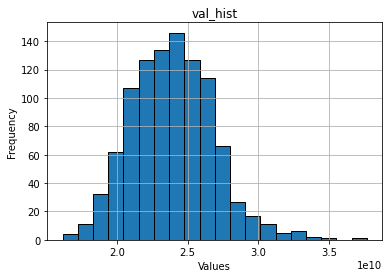

In [75]:
#this will only work if the networks have the same architecture
test_list = list(zip([row for row in neural_network.model.parameters() if len(row.shape) > 1],
                     [row for row in mymodel.parameters() if len(row.shape) > 1]))

for i in test_list:
    #this first line will print out the row similarity matrix.
    #print(compare_rows(i[0].detach().numpy(),i[1].detach().numpy())[0])
    print(compare_rows(i[0].detach().numpy(),i[1].detach().numpy())[1])
print('_______')  
# VALIDATION
iterations = 1000
val_samples = 100
m = 0.0
std = 1.0

val_list = []
for _ in range(iterations):
    val_inputs = torch.from_numpy(np.random.normal(m, std, (val_samples,layer_sizes[0])).astype(np.float32))
    val_outputs = neural_network.model(val_inputs)
    this_val_acc = calculate_validation_loss(mymodel, val_inputs, val_outputs, criterion)
    val_list.append(this_val_acc)
    
val_histogram(val_list, bins=20, title="val_hist", xlabel="Values", ylabel="Frequency")

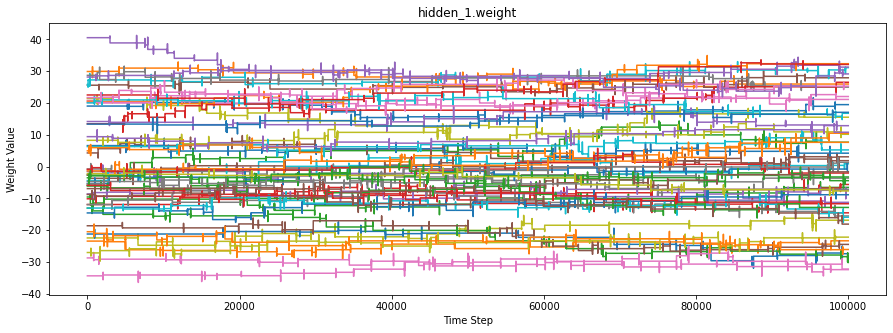

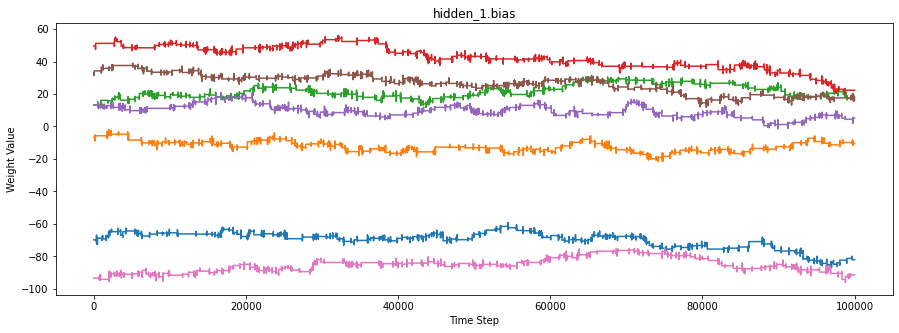

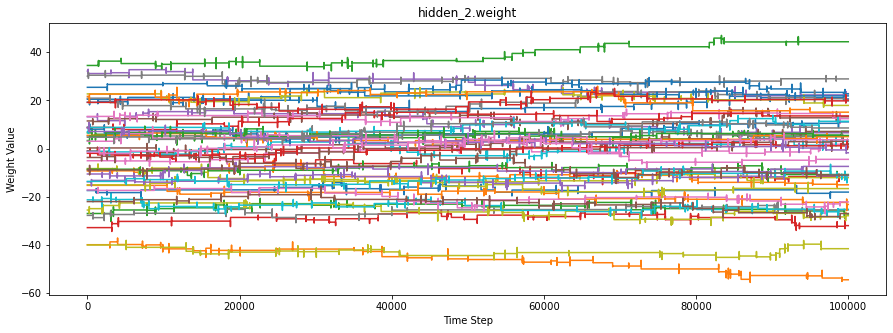

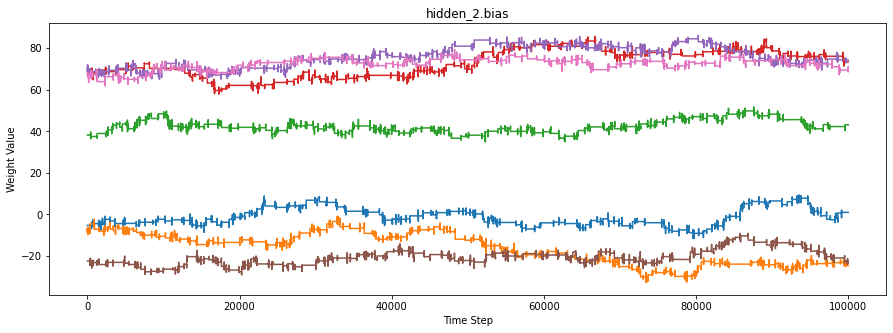

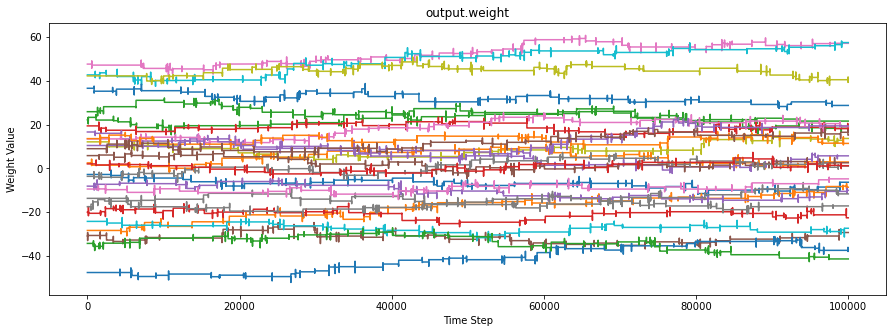

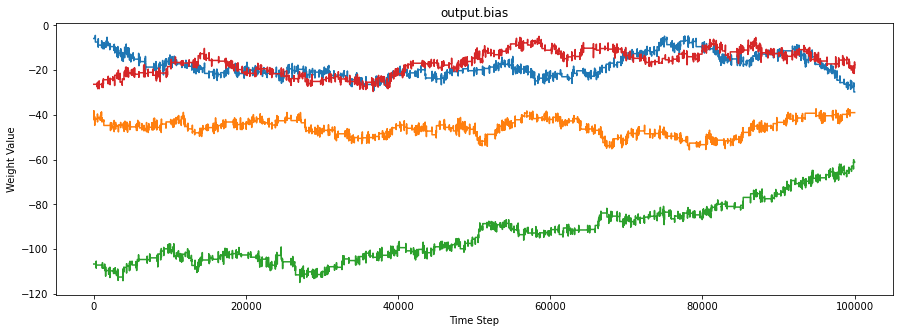

In [45]:
##x_range = (99998,100000) to view final weights
lab.graph(diff=0,graph_together = False, plot_size = (15,5) )

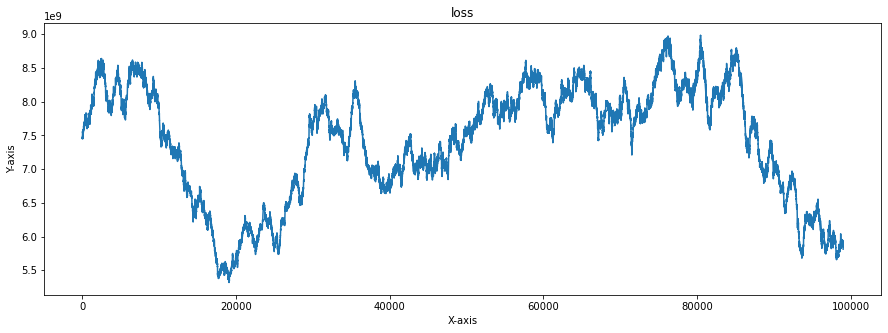

In [46]:
plot_line_graph(losses,window_size = 1000, plot_size = (15,5)) #window_size is the moving average window

In [164]:
kappa_global[0]

[(13.124822616577148, 54258788.0),
 (13.378740310668945, 54258788.0),
 (12.723127365112305, 592270.4375),
 (11.41114330291748, 3155498.5),
 (12.214263916015625, 2660123.75),
 (14.251300811767578, 2523438.5),
 (14.133325576782227, 32550664.0),
 (14.830842971801758, 487503.5625),
 (11.913740158081055, 32001236.0),
 (11.851048469543457, 1680468.0),
 (14.818788528442383, 3271754.25)]

In [117]:
min_global

[16.73750114440918,
 0.9629045128822327,
 21.792659759521484,
 -0.4599241018295288,
 -6.182155132293701,
 5.329230785369873,
 0.2735172510147095,
 -0.34746837615966797,
 8.04106330871582]

In [ ]:
std_global